# Prototype for funtions required for processing of data 

---

Amnah Siddiqa

November 02, 2022

----


In [1]:
shhh <- suppressPackageStartupMessages # It's a library, so shhh!
shhh(library(tidyverse))
library(dplyr)
library(pheatmap)
library(dplyr)
shhh(library(RColorBrewer))
shhh(library(data.table))
shhh(library(FactoMineR))
shhh(library(factoextra))
shhh(library(tidyverse))
library(repr)#jupyter notebook R ; image manipulation 

In [2]:
#remove background peaks
tagfeaturestoremoveBG<-function(bg_df, signal_df){
  
  #Input files bg_df and signal_df are of following shape  with zeros as returned by asari 
  # batch1_Blank_20221018_001 batch1_Blank_20221018_003 batch1_Blank_20221018_005 
  # F7                          0                         0                         0                               
  # F11                         0                         0                         0                       
  # F15                    116514                    170992                     93020                         
  
  #step1
  #select the features which are detected in least a blank sample
  #if row sum of blank samples is greater than 0 ; 
  # cz asari has zeros as mising values ; have to first convert them to NAs for correct mean calculations 
  bg_df[bg_df==0 ]<-NA
  bg_df<-bg_df[rowSums(bg_df, na.rm=TRUE)>0, ]
  #dim(bg_df)
  
  #get the background samples mean values of features 
  bg_df<-data.frame(Fid=rownames(bg_df),bkgmean=rowMeans(bg_df, na.rm=TRUE))
 
  #get the signal mean values 
  signal_df[signal_df==0]<-NA
  signal_df<-data.frame(Fid=rownames(signal_df), signalmean=rowMeans(signal_df,na.rm=TRUE))
  
   #get the data combined for signal_df and bg_df means for all features 
  combined_df<-left_join(bg_df, signal_df, by="Fid")
  
   #if signal mean is 3x greater than the background mean vakues keep that feature else remove that feature 
  combined_df<-combined_df%>%mutate(filterValue=ifelse(signalmean > (3*bkgmean), "keep", "remove"))
  
  
  ## remove tag ;  signal mean value was lower 
  combined_df<-combined_df%>%filter(filterValue=="remove")
  #head(combined_df)
  #dim(combined_df)
  
  return(combined_df)
}


In [23]:
tagfeaturestokeepGroupwise<-function(metadata, ft, percentage, groupcol,fileNamecol){
  
  #Input file metadata should look like this and must have columns 
  # A data.frame: 6 × 5
  # SampleType	FileName	SampleID	batch	FileNameEdits
  # <chr>	<chr>	<chr>	<chr>	<chr>
  #   1	Sample	MT_20221018_011	Leu_M_02_01	batch1	batch1_MT_20221018_011
  # 2	Sample	MT_20221018_013	DHEAS_L_03_01	batch1	batch1_MT_20221018_013
  # 3	Sample	MT_20221018_015	Phe_H_01_01	batch1	batch1_MT_20221018_015  
  #   
  
  
  # percentage is any number between 0-1
  
  
  #Input files bg_df and signal_df are of following shape  with zeros as returned by asari 
  # batch1_Blank_20221018_001 batch1_Blank_20221018_003 batch1_Blank_20221018_005 
  # F7                          0                         0                         0                               
  # F11                         0                         0                         0                       
  # F15                    116514                    170992                     93020                         
  
  
  #groupcol is the name of column in metadata you want to use for filtering 
  
  # fileNamecol is name of file namessol
  
  #groupwise filtering 
  groups=unique(metadata_df[[groupcol]])
  groups
  #percentage=0.8
  length(groups)
  masterft<-data.frame()
  for (agroup in 1:length(groups)){
    #print("..")
    metadata_df2<-filter(metadata_df,metadata_df[[groupcol]]==groups[agroup])
    ft_subset<-ft%>% select_if((names(.) %in% metadata_df2[[fileNamecol]]))
    #Detection count is present values in features 
    ft_subset$DetectionCount<- rowSums(ft_subset != 0)
    #keep the features which have at least X percent presence in group 
    ft_subset<-ft_subset%>%filter(DetectionCount >= (ncol(ft_subset)*percentage))
    ft_subset<-data.frame(Fid=row.names(ft_subset))
    masterft<-rbind(masterft, ft_subset)
  }
  
  masterft<-unique(masterft)
  return(masterft)
}



In [24]:
getwd()

[1] "/home/jovyan/work/Documents/GitHub/MasterRepos/AnalyticalWorkflows/Notebooks"

## Data prep

In [4]:
FT="../TestData/preferred_Feature_table.tsv"
#FT="../HILICPOS/asari_output/preferred_Feature_table.tsv"
## read feature data; this is asari table
ft<-read.table(FT, 
               sep="\t", header = TRUE)
print(dim(ft))
#colnames(ft)[1:12]
row.names(ft)<-ft$id_number
head(ft)

[1] 31282   186


,id_number,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,⋯,batch2_MT_20221019_151,batch2_MT_20221019_153,batch2_MT_20221019_155,batch2_MT_20221019_157,batch2_MT_20221019_159,batch2_MT_20221019_161,batch2_MT_20221019_163,batch2_MT_20221019_165,batch2_MT_20221019_167,batch2_MT_20221019_169
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F3,F3,67.0548,224.28,219.61,251.63,3,41654322,1.00,0.81,74,⋯,0,284953,311033,282488,289498,389188,0,350296,279933,257024
F5,F5,67.1903,189.70,188.65,190.74,4,1368410,1.00,0.74,24,⋯,0,0,0,0,0,0,0,0,0,0
F7,F7,67.2507,141.60,138.74,144.29,8,789870563,1.00,0.93,6970,⋯,0,0,13252984,0,0,0,0,13173610,0,0
F11,F11,68.9939,1.59,1.03,2.93,10,22901904,1.00,0.91,766,⋯,328122,157086,0,0,0,0,113512,0,0,0
F13,F13,69.0341,171.31,169.70,174.17,11,4985349,0.92,0.85,72,⋯,0,0,13734,0,0,0,0,0,50653,312163
F14,F14,69.0341,215.55,211.42,218.53,11,4278112,0.96,0.82,35,⋯,0,0,128102,0,0,0,187204,0,123795,0


## Filter features > snr 100

signalto noise ratio is defined as : the non signal data points than peaks (all peaks present) in a masstrack; 

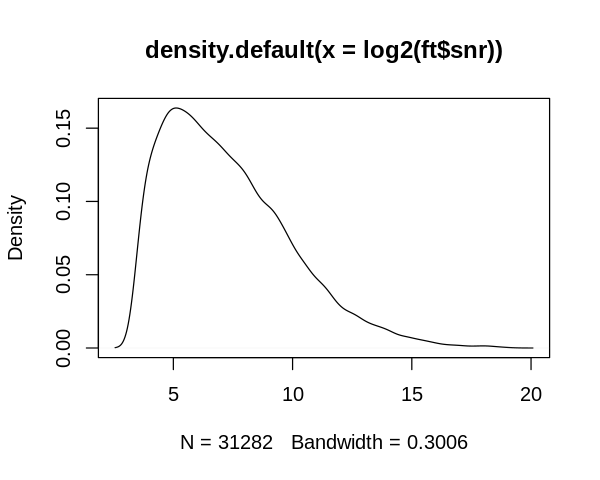

In [5]:
options(repr.plot.width=5, repr.plot.height=4, res=200)
plot(density(log2(ft$snr)))

In [6]:
#remove features with snr > 100
ft<-ft%>%filter(snr > 100)
dim(ft)

[1] 16372   186

In [9]:
#read metadata 
metadatafile="../TestData/metadata.csv"
metadata_df<-read.table(metadatafile, quote = "", sep=",", header = TRUE, check.names = FALSE)

head(metadata_df)
#change the names of the files with sample names 
#colnames(metadata)

,SampleType,FileName,SampleID,batch,FileNameEdits,SampleType2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Blank,Blank_20221018_001,Blank_20221018_001,batch1,batch1_Blank_20221018_001,Blank
2,Blank,Blank_20221018_003,Blank_20221018_003,batch1,batch1_Blank_20221018_003,Blank
3,Blank,Blank_std_20221018_1_001,Blank_std_20221018_001,batch1,batch1_Blank_std_20221018_1_001,Blank
4,QC,MT_20221018_001,Qstd_20221018_001,batch1,batch1_MT_20221018_001,QC
5,QC,MT_20221018_003,Qstd_20221018_003,batch1,batch1_MT_20221018_003,QC
6,QC,MT_20221018_005,Qstd_20221018_005,batch1,batch1_MT_20221018_005,QC


## Filter features 3x > bg signal 
- Data is of this format ; Features 2 samples 
- Contains 0s as returned by asari but functions take care of it when drawing mean by converting them in nas and then taking suym or means

In [10]:
unique(metadata_df$SampleType)

[1] "Blank"  "QC"     "NIST"   "Pooled" "Sample"

In [11]:
# Remove 3x bckground signals fetures -------------------------------------
bkgfiles=metadata_df%>%filter(SampleType=="Blank")
#choose blank samples 
bkg=ft%>%select_if(names(.) %in% bkgfiles$FileNameEdits)

head(bkg)


# all samples including Qstd , Pooled and biosamples are included in signal files 
signalfiles=metadata_df%>%filter(!SampleType=="Blank")
signal=ft%>%select_if(names(.) %in%signalfiles$FileNameEdits)

head(signal)


,batch1_Blank_20221018_001,batch1_Blank_20221018_003,batch1_Blank_20221018_005,batch1_Blank_std_20221018_1_001,batch2_Blank_20221019_001,batch2_Blank_20221019_003,batch2_Blank_20221019_005,batch2_Blank_std_20221019_1_001
,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
F7,0,0,0,0,0,0,0,0
F11,0,0,0,0,0,329866,0,0
F15,116514,170992,93020,61463,76082,7741,65736,19573
F20,0,0,0,0,0,0,0,0
F21,0,0,335441,0,0,0,329703,0
F24,0,0,0,0,0,0,0,5529


,batch1_MT_20221018_147,batch1_MT_20221018_001,batch1_MT_20221018_003,batch1_MT_20221018_005,batch1_MT_20221018_007,batch1_MT_20221018_009,batch1_MT_20221018_011,batch1_MT_20221018_013,batch1_MT_20221018_015,batch1_MT_20221018_017,⋯,batch2_MT_20221019_151,batch2_MT_20221019_153,batch2_MT_20221019_155,batch2_MT_20221019_157,batch2_MT_20221019_159,batch2_MT_20221019_161,batch2_MT_20221019_163,batch2_MT_20221019_165,batch2_MT_20221019_167,batch2_MT_20221019_169
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F7,0,0,0,0,0,0,0,0,0,0,⋯,0,0,13252984,0,0,0,0,13173610,0,0
F11,0,0,0,0,0,0,0,0,0,0,⋯,328122,157086,0,0,0,0,113512,0,0,0
F15,11929721,28310539,29182687,28671044,27361167,14061539,15638423,7708689,9858212,9006167,⋯,9416806,8274997,5993130,6957273,5869877,6839305,3860720,5193095,6759427,14715891
F20,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
F21,12434917,41720312,41207863,40622031,118428,12604356,15438745,7020187,7857462,11432828,⋯,8760786,7461085,6478146,9019885,8553835,7157259,7020425,7841902,9906436,29523380
F24,0,338631,383801,441660,0,466973,573463,225125,0,165418,⋯,0,0,87039,146614,83072,165239,0,188325,0,0


In [12]:
taggedfeatures<-tagfeaturestoremoveBG(bkg,signal)
dim(taggedfeatures)

[1] 2637    4

In [13]:
#remove the features with 0 values in combined data 
ft<-ft%>%filter( !(row.names(ft) %in% taggedfeatures$Fid))
dim(ft)

[1] 13735   186

In [14]:
head(ft)

,id_number,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,⋯,batch2_MT_20221019_151,batch2_MT_20221019_153,batch2_MT_20221019_155,batch2_MT_20221019_157,batch2_MT_20221019_159,batch2_MT_20221019_161,batch2_MT_20221019_163,batch2_MT_20221019_165,batch2_MT_20221019_167,batch2_MT_20221019_169
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F7,F7,67.2507,141.60,138.74,144.29,8,789870563,1,0.93,6970,⋯,0,0,13252984,0,0,0,0,13173610,0,0
F15,F15,69.0704,123.49,114.87,132.63,17,1431589624,1,0.98,710,⋯,9416806,8274997,5993130,6957273,5869877,6839305,3860720,5193095,6759427,14715891
F20,F20,131.0338,171.66,171.13,176.14,2066,10815818,1,0.83,191,⋯,0,0,0,0,0,0,0,0,0,0
F21,F21,131.0338,192.81,186.32,215.17,2066,1774784772,1,0.93,9546,⋯,8760786,7461085,6478146,9019885,8553835,7157259,7020425,7841902,9906436,29523380
F24,F24,131.0451,187.76,183.30,189.35,2068,20487210,1,0.98,282,⋯,0,0,87039,146614,83072,165239,0,188325,0,0
F26,F26,131.0470,170.05,165.66,186.32,2069,1331590687,1,0.82,5339,⋯,5979284,5692525,3800534,4439133,3864755,5459333,2365371,2907067,3609852,5195421


In [15]:
colnames(ft)[1:20]

[1] "id_number"                       "mz"                             
 [3] "rtime"                           "rtime_left_base"                
 [5] "rtime_right_base"                "parent_masstrack_id"            
 [7] "peak_area"                       "cSelectivity"                   
 [9] "goodness_fitting"                "snr"                            
[11] "detection_counts"                "batch1_MT_20221018_147"         
[13] "MT_20221019_109_20221019204757"  "batch1_Blank_20221018_001"      
[15] "batch1_Blank_20221018_003"       "batch1_Blank_20221018_005"      
[17] "batch1_Blank_std_20221018_1_001" "batch1_MT_20221018_001"         
[19] "batch1_MT_20221018_003"          "batch1_MT_20221018_005"

In [16]:
metadata_df<-metadata_df%>%filter(SampleType=="Sample")
head(metadata_df)

,SampleType,FileName,SampleID,batch,FileNameEdits,SampleType2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Sample,MT_20221018_011,Leu_M_02_01,batch1,batch1_MT_20221018_011,Leu_M
2,Sample,MT_20221018_013,DHEAS_L_03_01,batch1,batch1_MT_20221018_013,DHEAS_L
3,Sample,MT_20221018_015,Phe_H_01_01,batch1,batch1_MT_20221018_015,Phe_H
4,Sample,MT_20221018_017,Phe_L_02_01,batch1,batch1_MT_20221018_017,Phe_L
5,Sample,MT_20221018_019,Arg_M_01_01,batch1,batch1_MT_20221018_019,Arg_M
6,Sample,MT_20221018_021,DHEAS_M_01_01,batch1,batch1_MT_20221018_021,DHEAS_M


In [17]:

#choose the biosamples only  ; no doing on all samples ; 
ft<-ft%>% select_if((names(.) %in% metadata_df$FileNameEdits))
#colnames(ft)
print(dim(ft))

head(ft)

[1] 13735   140


,batch1_MT_20221018_147,batch1_MT_20221018_011,batch1_MT_20221018_013,batch1_MT_20221018_015,batch1_MT_20221018_017,batch1_MT_20221018_019,batch1_MT_20221018_021,batch1_MT_20221018_023,batch1_MT_20221018_025,batch1_MT_20221018_027,⋯,batch2_MT_20221019_147,batch2_MT_20221019_149,batch2_MT_20221019_151,batch2_MT_20221019_153,batch2_MT_20221019_155,batch2_MT_20221019_157,batch2_MT_20221019_159,batch2_MT_20221019_161,batch2_MT_20221019_163,batch2_MT_20221019_165
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F7,0,0,0,0,0,0,0,0,23391967,0,⋯,0,0,0,0,13252984,0,0,0,0,13173610
F15,11929721,15638423,7708689,9858212,9006167,9511865,7804080,11285070,9847075,13799424,⋯,7918144,5705248,9416806,8274997,5993130,6957273,5869877,6839305,3860720,5193095
F20,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
F21,12434917,15438745,7020187,7857462,11432828,10189678,6099497,15349339,12157851,10841047,⋯,9722508,5822892,8760786,7461085,6478146,9019885,8553835,7157259,7020425,7841902
F24,0,573463,225125,0,165418,199520,0,211380,264121,0,⋯,189212,177520,0,0,87039,146614,83072,165239,0,188325
F26,9562750,9711141,4153599,5564472,4994774,4245783,2990832,4885046,5589240,7828907,⋯,5325017,4576722,5979284,5692525,3800534,4439133,3864755,5459333,2365371,2907067


# Groupwise Filtering 

In [18]:
 #groupwise filtering 
  percentage=0.8
  listoffetaturestokeep=tagfeaturestokeepGroupwise(metadata, ft, percentage, "SampleType2", "FileNameEdits")
  
head( listoffetaturestokeep)

,Fid
,<chr>
1,F15
2,F21
3,F26
4,F27
5,F30
6,F35


In [19]:
#Keep the filtered features by presence 
ft<-ft%>%filter( (row.names(ft) %in% listoffetaturestokeep$Fid))
dim(ft)

[1] 7489  140

In [20]:
head(ft)

,batch1_MT_20221018_147,batch1_MT_20221018_011,batch1_MT_20221018_013,batch1_MT_20221018_015,batch1_MT_20221018_017,batch1_MT_20221018_019,batch1_MT_20221018_021,batch1_MT_20221018_023,batch1_MT_20221018_025,batch1_MT_20221018_027,⋯,batch2_MT_20221019_147,batch2_MT_20221019_149,batch2_MT_20221019_151,batch2_MT_20221019_153,batch2_MT_20221019_155,batch2_MT_20221019_157,batch2_MT_20221019_159,batch2_MT_20221019_161,batch2_MT_20221019_163,batch2_MT_20221019_165
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F15,11929721,15638423,7708689,9858212,9006167,9511865,7804080,11285070,9847075,13799424,⋯,7918144,5705248,9416806,8274997,5993130,6957273,5869877,6839305,3860720,5193095
F21,12434917,15438745,7020187,7857462,11432828,10189678,6099497,15349339,12157851,10841047,⋯,9722508,5822892,8760786,7461085,6478146,9019885,8553835,7157259,7020425,7841902
F26,9562750,9711141,4153599,5564472,4994774,4245783,2990832,4885046,5589240,7828907,⋯,5325017,4576722,5979284,5692525,3800534,4439133,3864755,5459333,2365371,2907067
F27,3457018,3604002,1340719,2158727,2947011,2109060,1609750,3287503,2569678,3017570,⋯,2274690,1176394,2028549,1818083,1277728,1993387,2168307,1605067,1926829,1548306
F30,6198690,8725693,3020166,3450506,3354633,3357627,2087471,4104265,3832823,6535859,⋯,3644792,3131712,4439506,3907212,2618649,3225038,2348977,3906519,1855460,2084298
F35,52678913,51473232,23386379,27489933,24558149,26409431,14215777,30916827,28377048,44559373,⋯,27915952,22964256,35184203,29054576,20567480,23527008,17948403,25442403,14461808,15972853


In [21]:
#filter by presence in > 70% samples
#ft<-ft%>%filter(detection_counts >= (ncol(ft)-4)*0.70)
#print(dim(ft))
ft.expr<-ft

#imputing 0s with minimim row values > 0 
ft.expr<-apply(ft.expr, 1, function(x) "[<-"(x, x==0, min(x[x > 0])/2))%>%t()%>%data.frame()
#log 
ft.expr<-log2(ft.expr+1)
range(ft.expr)

head(ft.expr)

[1] 11.26151 36.03406

,batch1_MT_20221018_147,batch1_MT_20221018_011,batch1_MT_20221018_013,batch1_MT_20221018_015,batch1_MT_20221018_017,batch1_MT_20221018_019,batch1_MT_20221018_021,batch1_MT_20221018_023,batch1_MT_20221018_025,batch1_MT_20221018_027,⋯,batch2_MT_20221019_147,batch2_MT_20221019_149,batch2_MT_20221019_151,batch2_MT_20221019_153,batch2_MT_20221019_155,batch2_MT_20221019_157,batch2_MT_20221019_159,batch2_MT_20221019_161,batch2_MT_20221019_163,batch2_MT_20221019_165
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F15,23.50806,23.89859,22.87805,23.23289,23.10248,23.18130,22.89580,23.42791,23.23126,23.71810,⋯,22.91673,22.44386,23.16681,22.98033,22.51488,22.73009,22.48490,22.70542,21.88044,22.30816
F21,23.56789,23.88005,22.74308,22.90563,23.44668,23.28061,22.54026,23.87167,23.53539,23.37000,⋯,23.21290,22.47330,23.06263,22.83095,22.62715,23.10468,23.02814,22.77098,22.74313,22.90277
F26,23.18899,23.21121,21.98593,22.40781,22.25199,22.01760,21.51212,22.21994,22.41422,22.90038,⋯,22.34435,22.12588,22.51154,22.44064,21.85777,22.08185,21.88195,22.38029,21.17364,21.47113
F27,21.72110,21.78117,20.35458,21.04175,21.49082,21.00817,20.61841,21.64856,21.29316,21.52496,⋯,21.11724,20.16594,20.95202,20.79399,20.28515,20.92679,21.04814,20.61420,20.87780,20.56226
F30,22.56353,23.05684,21.52620,21.71838,21.67772,21.67901,20.99333,21.96869,21.86998,22.63995,⋯,21.79741,21.57852,22.08197,21.89771,21.32039,21.62089,21.16360,21.89745,20.82335,20.99113
F35,25.65072,25.61732,24.47917,24.71240,24.54970,24.65455,23.76099,24.88189,24.75822,25.40923,⋯,24.73459,24.45289,25.06842,24.79226,24.29386,24.48781,24.09735,24.60073,23.78574,23.92912


write.table (ft.expr,
             "FT.tsv", 
             row.names=TRUE,
             sep="\t")